<a href="https://colab.research.google.com/github/GulsumSayin/OSCC-Histopathology-Classification/blob/main/OSCC_EfficientNetV2B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Veri Setinin Alınması

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri klasörleri
base_dir = "/content/drive/MyDrive/final_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Ayarlar
image_size = (224, 224)
batch_size = 32

# Train için augmentasyon + normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Val ve test: sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Veri yükleyiciler
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Test için önemli
)

# 🧾 Kontrol
print("✅ Train sınıfları:", train_data.class_indices)
print("✅ Val sınıfları:", val_data.class_indices)
print("✅ Test sınıfları:", test_data.class_indices)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
✅ Train sınıfları: {'normal': 0, 'oscc': 1}
✅ Val sınıfları: {'normal': 0, 'oscc': 1}
✅ Test sınıfları: {'normal': 0, 'oscc': 1}


#### Modelin Oluşturulması

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryFocalCrossentropy

def build_effnetv2_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # fine-tuning açık

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # binary sınıflama

    model = Model(inputs=base_model.input, outputs=output)
    return model

model=build_effnetv2_model()
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,247,505 (23.83 MB)

 Trainable params: 6,186,897 (23.60 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryFocalCrossentropy(gamma=2.0),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau: val_loss durursa lr'i azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Erken durdurma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

callbacks = [early_stop,reduce_lr]

**Model Eğitimi**

In [ ]:
# 🏋️‍♂️ Model eğitimi
history_1 = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 914s 11s/step - accuracy: 0.6106 - loss: 0.1764 - precision: 0.6094 - recall: 0.6737 - val_accuracy: 0.6767 - val_loss: 0.1496 - val_precision: 0.6345 - val_recall: 0.8333 - learning_rate: 1.0000e-04
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 608s 8s/step - accuracy: 0.7972 - loss: 0.1159 - precision: 0.7992 - recall: 0.7891 - val_accuracy: 0.7733 - val_loss: 0.1264 - val_precision: 0.9659 - val_recall: 0.5667 - learning_rate: 1.0000e-04
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 595s 8s/step - accuracy: 0.8385 - loss: 0.0929 - precision: 0.8428 - recall: 0.8361 - val_accuracy: 0.8100 - val_loss: 0.1024 - val_precision: 0.7435 - val_recall: 0.9467 - learning_rate: 1.0000e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 595s 8s/step - accuracy: 0.8830 - loss: 0.0730 - precision: 0.8902 - recall: 0.8780 - val_accuracy: 0.8033 - val_loss: 0.1114 - val_precision: 0.7358 - val_recall: 0.9467 - learning_rate: 1.0000e-04
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 609s 8s/step 

#### Model Performansının Görselleştirilmesi

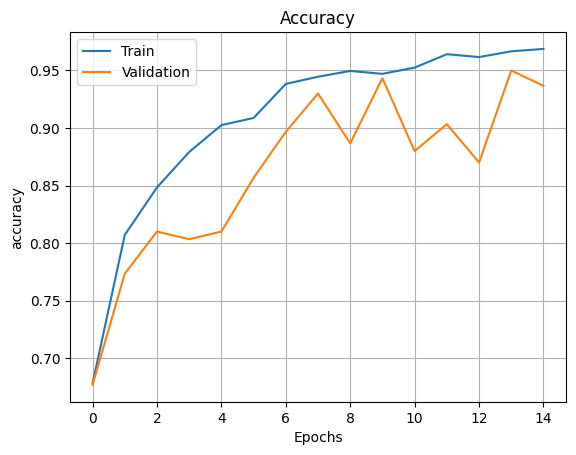

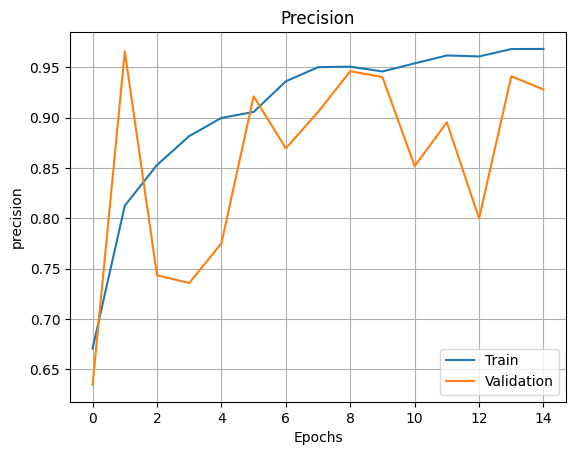

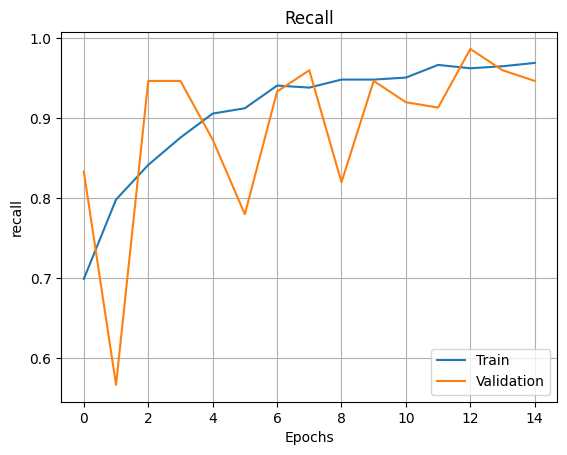

In [ ]:
# Eğitim metriklerini görselleştir
def plot_training(history):
    metrics = ['accuracy', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Validation')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history_1)

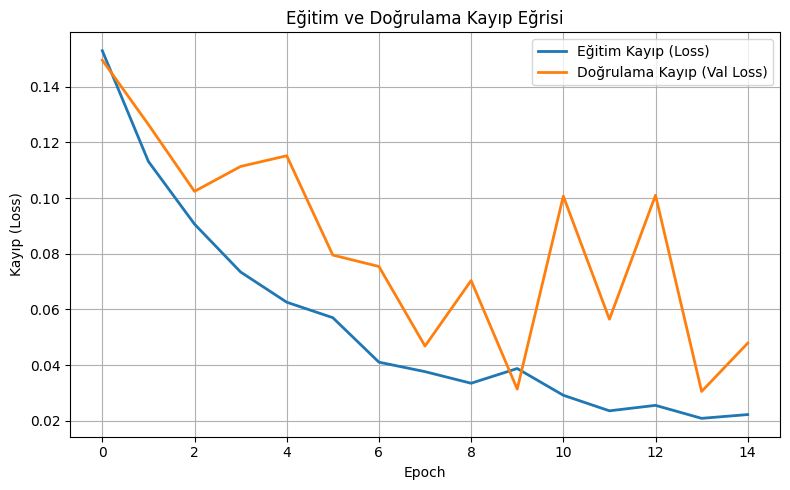

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)', linewidth=2)
    plt.title('Eğitim ve Doğrulama Kayıp Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(history_1)

#### Modelin Test Edilmesi

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step
Optimal threshold: 0.48809034


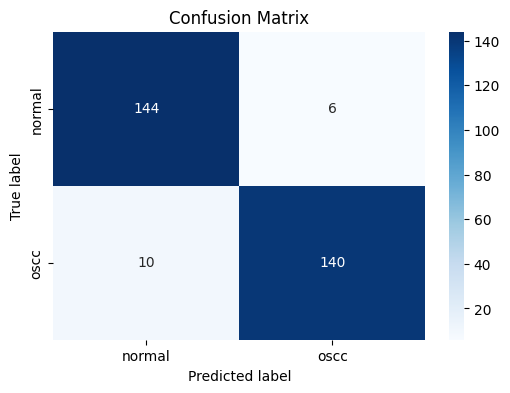

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.94      0.96      0.95       150
        oscc       0.96      0.93      0.95       150

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

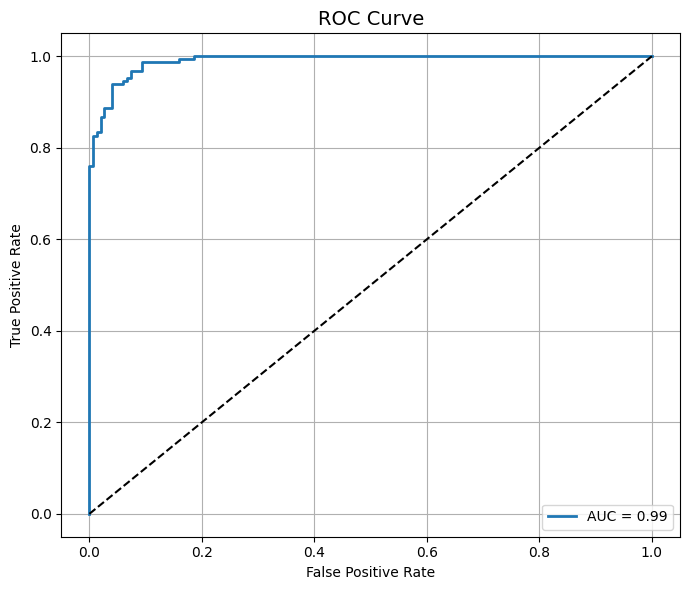

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa Skoru:", kappa)

Cohen's Kappa Skoru: 0.8933333333333333


**Modelin Kaydedilmesi**

In [ ]:
model.save('/content/drive/MyDrive/efficientNetV2B0_model.keras')

#### Grad CAM

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_activation", pred_index=None):
    """
    EfficientNetV2B0 gibi modellerde Grad-CAM için heatmap üretir
    img_array: (1,H,W,3), [0,1] normalize
    last_conv_layer_name: EfficientNetV2B0 için genellikle 'top_activation' veya 'block6a_project_bn'
    """
    # 1) Hedef katmanı al
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # 2) Ara model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            if predictions.shape[-1] == 1:  # sigmoid
                class_channel = predictions[:, 0]
            else:
                pred_index = tf.argmax(predictions[0])
                class_channel = predictions[:, pred_index]
        else:
            class_channel = predictions[:, pred_index]

    # 3) Grad-CAM hesapla
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-12)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name="top_activation", alpha=0.5, target_size=(224, 224)):
    """
    Görseli yükler, Grad-CAM uygular ve çıktıyı görselleştirir
    """
    # Görseli yükle ve normalize et
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Heatmap üret
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

    # Görsel üzerine bindir
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, target_size)
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 1 - alpha, heatmap_colored, alpha, 0)

    # Görselleştir
    plt.figure(figsize=(11, 4))
    plt.suptitle(f"Grad-CAM (layer: {last_conv_layer_name})", y=1.02)
    plt.subplot(1, 3, 1); plt.title("Original");     plt.imshow(img_cv[..., ::-1]); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("Grad-CAM");     plt.imshow(heatmap, cmap='jet'); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Superimposed"); plt.imshow(superimposed[..., ::-1]); plt.axis("off")
    plt.tight_layout(); plt.show()

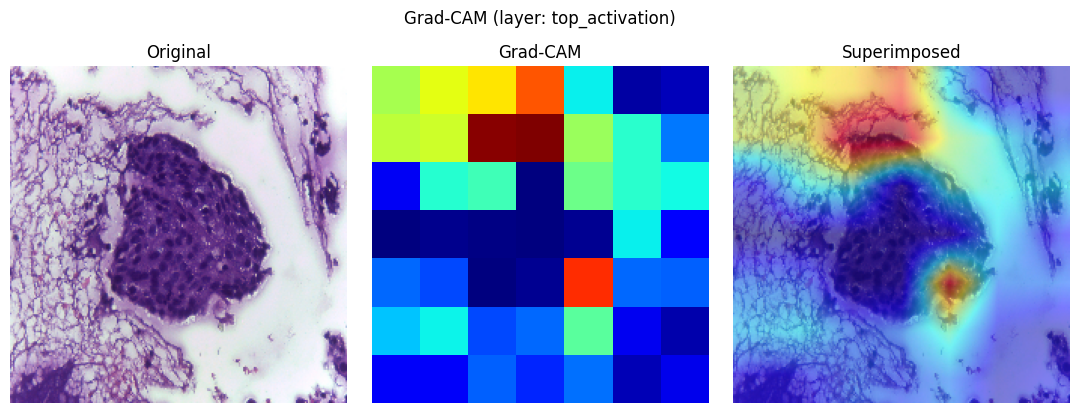

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"

# En yaygın isimlerden biri olan "top_activation" kullanılabilir:
display_gradcam(img_path, model, last_conv_layer_name="top_activation")

#### Integrated Gradients

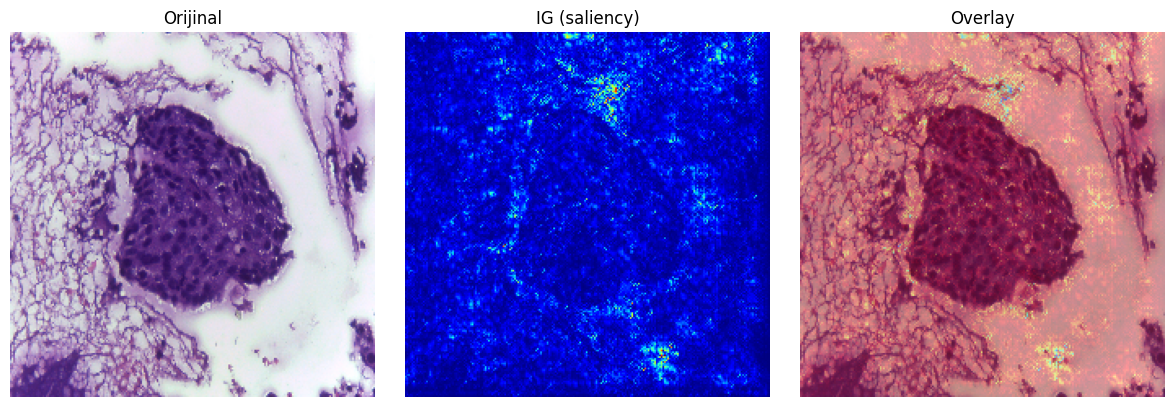

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# --- Yardımcılar ---
@tf.function
def compute_gradients(images):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images, training=False)  # önemli: training=False
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        output = preds[:, 0]  # binary: tek nöron
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, img_batch, m_steps=50, method="trapezoid"):
    # baseline ve img_batch şekilleri: (1, H, W, 3)
    alphas = tf.linspace(0.0, 1.0, m_steps)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = img_batch - baseline
    interpolated = baseline + alphas_x * delta   # (m, H, W, 3)

    grads = compute_gradients(interpolated)      # (m, H, W, 3)

    if method == "trapezoid" and m_steps > 1:
        grads = (grads[1:] + grads[:-1]) / 2.0   # trapez yaklaşımı

    avg_grads = tf.reduce_mean(grads, axis=0).numpy()      # (H, W, 3)
    integrated = (img_batch.numpy()[0] - baseline.numpy()[0]) * avg_grads  # (H,W,3)
    return integrated

def visualize_ig(img_path, target_size=(224,224), m_steps=50, baseline_type="black", save_path=None):
    # 1) görseli yükle
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    img_batch = np.expand_dims(img_arr, axis=0) / 255.0

    # 2) baseline seç
    if baseline_type == "black":
        baseline = tf.zeros_like(img_batch)
    elif baseline_type == "white":
        baseline = tf.ones_like(img_batch)
    elif baseline_type == "blur":
        # basit blur baseline
        blurred = cv2.GaussianBlur(img_arr, (51,51), 0) / 255.0
        baseline = tf.convert_to_tensor(np.expand_dims(blurred, 0), dtype=tf.float32)
    else:
        raise ValueError("baseline_type 'black' | 'white' | 'blur' olmalı.")

    # 3) IG hesapla
    ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch, dtype=tf.float32),
                              m_steps=m_steps, method="trapezoid")

    # 4) tek kanal önem haritası (abs ve normalize)
    attr = np.mean(np.abs(ig), axis=-1)
    attr -= attr.min()
    attr /= (attr.max() + 1e-12)

    # 5) görselleştir
    heatmap = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_arr.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Orijinal");     plt.imshow(img_arr.astype(np.uint8)); plt.axis("off")
    plt.subplot(1,3,2); plt.title("IG (saliency)"); plt.imshow(attr, cmap="jet");         plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay");       plt.imshow(overlay);                  plt.axis("off")
    plt.tight_layout(); plt.show()

    if save_path is not None:
        cv2.imwrite(save_path, overlay[..., ::-1])  # BGR yazdığı için ters çeviriyoruz
        print("Kaydedildi ->", save_path)

# --- KULLANIM ---
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)

**Modelin Yüklenmesi**

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/efficientNetV2B0_model.keras")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

#img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"  # örnek yol
img_path="/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
#img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
img_array = img_array / 255.0  # Normalize

In [ ]:
pred_prob = model.predict(img_array)[0][0]

threshold = optimal_threshold  # veya ROC ile optimize ettiğin değer
pred_label = "OSCC" if pred_prob > threshold else "Normal"

print(f"Model çıktısı (olasılık): {pred_prob:.4f}")
print(f"Tahmin edilen sınıf: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Model çıktısı (olasılık): 0.0787
Tahmin edilen sınıf: Normal


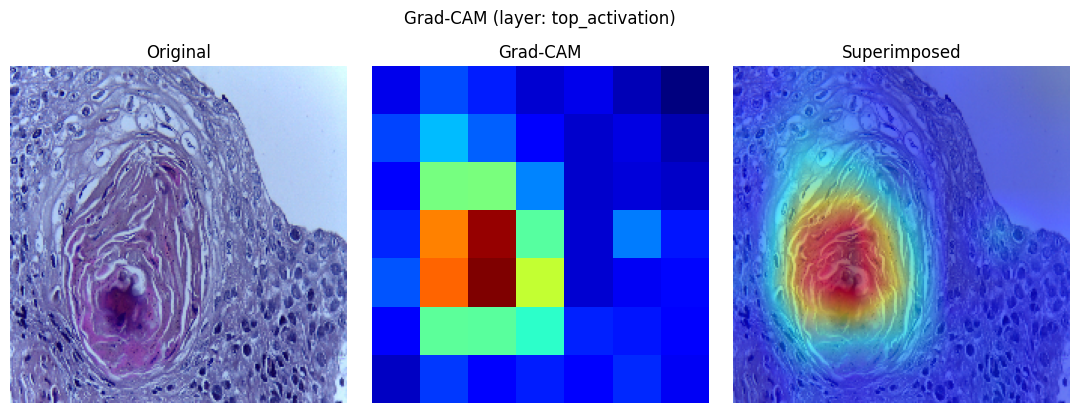

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_462.jpg"

# En yaygın isimlerden biri olan "top_activation" kullanılabilir:
display_gradcam(img_path, model, last_conv_layer_name="top_activation")

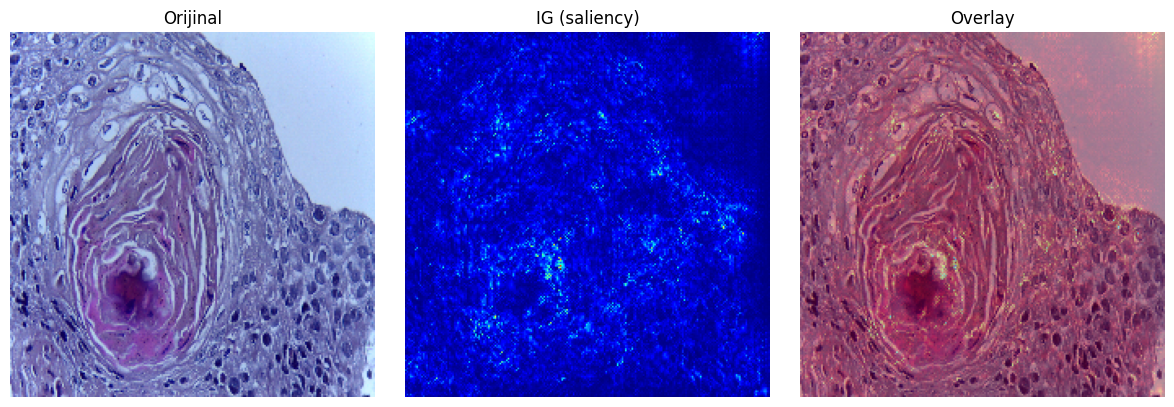

In [ ]:
# --- KULLANIM ---
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_462.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)

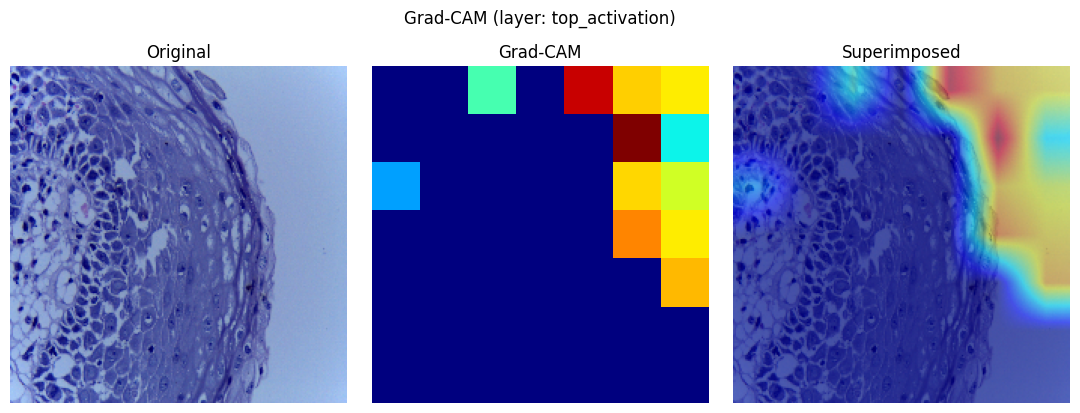

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
# En yaygın isimlerden biri olan "top_activation" kullanılabilir:
display_gradcam(img_path, model, last_conv_layer_name="top_activation")

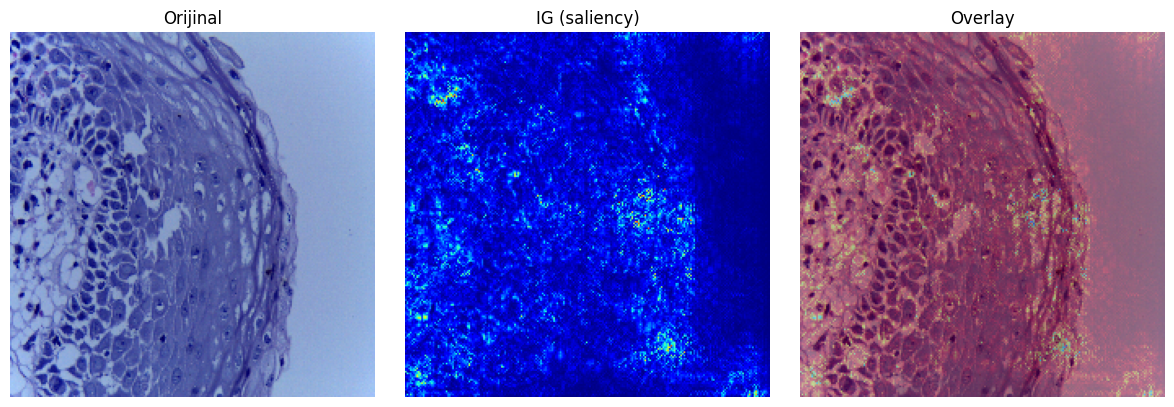

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)